# First Assignment

A company produces a set of products at $I$ plants. It then ships these products to $J$ market zones.
For $i = 1,...,I$ and $j = 1,...,J$, the following data are given:

$v_{i} \equiv$ variable cost of producing one unit of product at plant $i$.

$c_{ij} \equiv$ cost of shipping one unit of product from plant $i$ to market $j$.

$d_{j} \equiv$ demand for products at market $j$.

$M_{i} \equiv$ maximum number or products produced at plant $i$.

$p_{j} \equiv$ selling price for products at market $j$.

$F \equiv $ maximum transportation capacity between plant $i$ and market $j$ (assume all transportation capacities are equal).

**a)** Formulate the problem (linear program) of maximizing the total profit that the
company is facing (total selling revenue - total production and transportation costs) by
identifying the optimal production and transportation schedule. Assume also that demand
is satisfy with "equality", i.e., "total product reaching market $j$" = $d_{j}$ ).

#### SOLUTION

First of all, the $I \cdot J$ variables of our problem are the following ones:

$X_{ij} \equiv$ units produced in market $i$ and sold in market $j$.  

Then the optimization problem is:

 $$ \max (\sum_{i=1}^{I}  \sum_{j=1}^{J} p_{j} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} v_{i} c_{ij} X_{ij})$$


s.t.

$\displaystyle \sum_{i=1}^{I} X_{ij} = d_{j} \quad j=1,...,J \quad $  (We have to satisfy the demand of $J$ markets)

$\displaystyle \sum_{j=1}^{J} X_{ij} \le M_{i} \quad i=1,...,I \quad $  (We can not produce more than the capacity for each of the $I$ plants)

$X_{ij} \le F \quad j=1,...,J \quad i=1,...,I \quad $ (We can not transport more than $F$ from plant $i$ to market $j$)

$X_{ij} \ge 0 \quad j=1,...,J \quad i=1,...,I \quad $ (We can not produce negative units)

**b)** Implement the model in Pyomo as an "AbstractModel()" and solve it considering
5 plants and 6 markets and randomly generated parameters. For the random generation of
these parameters consider uniform distributions within the following ranges: $v_{i} \in [1.5 , 2.5] $,
$c_{ij} \in [1,2]$, $dj \in [275, 325]$, $M_{i} \in [400, 900]$, $p_{j} \in [4, 5]$ and  $F \in[250, 350]$.

Random variable declaration

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
np.random.seed()
################ DATA #####################
n_plants=5; #number of factories
n_markets=6; #number of markets

# 6 production cost for plant i
plant_cost = np.random.rand(n_plants) + 1.5

# 5 maximum capacity at plant i
max_cap = np.random.rand(n_plants) * 500 + 400

# 2 cost of shipping one unit of product from plant i to market j.
trans_cost = np.random.rand(n_plants,n_markets) + 1

# 3 demand for products at market j
market_dem = np.random.rand(n_markets) * 50 + 275

# 4 selling price at market j
sell_price = np.random.rand(n_markets) + 4

# 1 Transportation capacity 
trans_cap = np.ones((n_plants,n_markets))*np.random.uniform(low=250, high=350, size=1)[0]

Creating model

In [56]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def trans_opt(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)

    
    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value

    return instance.OBJ(), x_sol

In [57]:
obj,x_sol=trans_opt(n_plants,n_markets,plant_cost,trans_cost,market_dem,max_cap,sell_price,trans_cap)

In [58]:
obj

2285.298048787304

In [59]:
x_sol

array([[  39.05349101,    0.        ,  316.51793048,    0.        ,
         308.36656161,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 243.76715811,    0.        ,    0.        ,  314.99859567,
           0.        ,  299.80517594],
       [   0.        ,  291.50133395,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ]])

**c)i)** Considering the results: which plant's maximum capacity would be more benecial
to increase? Justify
your answers.

The original plant capacities where:
[ 1190.90157399  2072.13682872  1685.88461919   732.66689187   408.08424798]
('Value for obj increasing in plant', 1, ' is ', 2334.413156171067)
('Value for obj increasing in plant', 2, ' is ', 2334.413156171067)
('Value for obj increasing in plant', 3, ' is ', 2334.413156171067)
('Value for obj increasing in plant', 4, ' is ', 2334.413156171067)
('Value for obj increasing in plant', 5, ' is ', 2334.413156171067)
('The profit will increase the most if the maximum capacity was increased for plant:', 1)


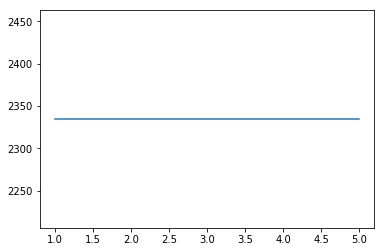

In [65]:
aux_obj = 0
aux_plant = -1
v_obj=np.zeros(n_plants)

print("The original plant capacities where:")
print(max_cap)
aux_capacity = max_cap
for plant in range(0, max_cap.size):
    aux_capacity[plant] = aux_capacity[plant]+1
    if(plant > 0):
        aux_capacity[plant-1] = aux_capacity[plant-1]-1
    obj,x_sol=trans_opt(n_plants,n_markets,plant_cost,trans_cost,market_dem,aux_capacity,sell_price,trans_cap)
    print("Value for obj increasing in plant", plant + 1, " is ", obj)
    v_obj[plant]=obj
    if aux_obj < obj:
        aux_obj = obj
        aux_plant = plant+1
      

print("The profit will increase the most if the maximum capacity was increased for plant:", aux_plant)
plt.plot(range(1,n_plants+1),v_obj)

We can also observe graphically how the profit rises while we increase the plants capacity:

[ 1190.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1200.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1210.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1220.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1230.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1240.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1250.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1260.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1270.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1280.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1290.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1300.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]
[ 1310.90157399  2072.13682872  1685.88461919   732.66689187   409.08424798]

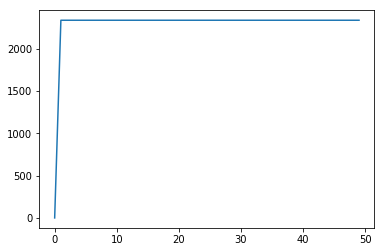

In [66]:
aux_plant = aux_plant -1
aux_capacity = max_cap
aux_obj = np.zeros(50)
for increase in range(1, 50):
    aux_capacity[aux_plant] = aux_capacity[aux_plant] + 10 
    aux_obj[increase],x_sol=trans_opt(n_plants,n_markets,plant_cost,trans_cost,market_dem,aux_capacity,sell_price,trans_cap)
    
plt.plot(range(0,aux_obj.size),aux_obj)

**c)ii)** and in which market would be more beneficial to increase the demand? Justify
your answers.

The original market demands where:
[ 292.0167132   303.47454974  276.83918245  324.05604481  301.03260835
  287.31032406]
('Value for obj increasing in market', 1, ' is ', 2719.2677186673395)
('Value for obj increasing in market', 2, ' is ', 2719.5882772562877)
('Value for obj increasing in market', 3, ' is ', 2719.411756652979)
('Value for obj increasing in market', 4, ' is ', 2719.6048703100855)
('Value for obj increasing in market', 5, ' is ', 2719.9009044872682)
('Value for obj increasing in market', 6, ' is ', 2719.2303019367127)
('The profit will increase the most if the demand was increased for market:', 5)


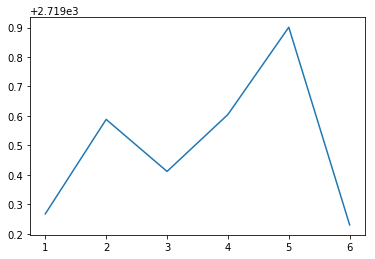

In [8]:
aux_obj = 0
aux_market = -1
v_obj=np.zeros(n_markets)

print("The original market demands where:")
print(market_dem)
aux_dem = market_dem
for market in range(0, market_dem.size):
    aux_dem[market] = aux_dem[market]+1
    if(market > 0):
        aux_dem[market-1] = aux_dem[market-1]-1
    obj,x_sol=trans_opt(n_plants,n_markets,plant_cost,trans_cost,aux_dem,max_cap,sell_price,trans_cap)
    print("Value for obj increasing in market", market + 1, " is ", obj)
    v_obj[market]=obj
    if aux_obj < obj:
        aux_obj = obj
        aux_market = market+1
      

print("The profit will increase the most if the demand was increased for market:", aux_market)
plt.plot(range(1,n_markets+1),v_obj)

### D) Modifications

Modify the formulation in a) to impose that:<br>
1. Each plant is allowed to send its products to a maximum of 5 different markets. (For demonstrative reasons I changed the maximum value to 3)<br>
2. Plants, if operative, cannot produce less than 10% of their maximum capacity, i.e., a plant can produce either 0 products (if not operative) or a quantity greater than 10% of its maximum capacity (if operative).<br>
Solve the resulting model in Pyomo and interpret the new results. (tip: binary variables may
be needed).<br>

**SOLUTION 1**
 

**$Y_{ij} \equiv$ 1 if the plant $i$ sends units to market $j$, 0 if not.** 

Then the optimization problem is:

 $$ \max (\sum_{i=1}^{I}  \sum_{j=1}^{J} p_{j} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} v_{i} c_{ij} X_{ij})$$


new s.t.

$\displaystyle \sum_{j=1}^{J} Y_{ij} \le 5 \quad i=1,...,I \quad $  (**Each plant can not send to more than 5 markets**)

In [9]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def trans_opt_1(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)
    model.b = Var(model.I,model.J, within=Binary)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)
    
    #Binary representation maximum markets per plant
    def max_markets_constraint_rule(model, i): # return the expression to constrain the relation between i and j
        return sum(model.b[i,j] for j in model.J) <= 3
    
    model.max_markets_constraint_rule = Constraint(model.I, rule=max_markets_constraint_rule)
    
    #Limiting real numbers through binary model
    def bound_constraint_rule(model,i,j): 
        return model.x[i,j] <=  model.b[i,j]*M[i-1]
    
    model.bound_constraint_rule = Constraint(model.I,model.J,rule=bound_constraint_rule)

    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    s_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
                s_sol[i,j]=instance.b[i+1,j+1].value

    return instance.OBJ(), x_sol

In [10]:
obj_1,x_sol_1=trans_opt_1(n_plants,n_markets,plant_cost,trans_cost,market_dem,max_cap,sell_price,trans_cap)

In [11]:
print("The first objective was: ", obj, " and after the modification: ", obj_1)

('The first objective was: ', 2719.2303019367127, ' and after the modification: ', 2719.2303019367127)


In [12]:
print("Our first solution was: ")
print(x_sol)

Our first solution was: 
[[   0.            0.            0.            0.            0.            0.        ]
 [   0.          117.78328824    0.          196.04321643    0.
   288.31032406]
 [   0.            0.          276.83918245  128.01282838  301.03260835
     0.        ]
 [   0.            0.            0.            0.            0.            0.        ]
 [ 292.0167132   185.6912615     0.            0.            0.            0.        ]]


In [13]:
print("And the second one: ")
print(x_sol_1)

And the second one: 
[[   0.            0.            0.            0.            0.            0.        ]
 [   0.          117.78328824    0.          196.04321643    0.
   288.31032406]
 [   0.            0.          276.83918245  128.01282838  301.03260835
     0.        ]
 [   0.            0.            0.            0.            0.            0.        ]
 [ 292.0167132   185.6912615     0.            0.            0.            0.        ]]


**SOLUTION 2**

**$A_{i} \equiv$ 1 if the plant $i$ is active, 0 if not.** (This last variale is needed for the third constraint inequation due to the fact that, if the plant $i$ does not produce, then 0 would be greater or equal than a positive number)

new s.t.

$\displaystyle \sum_{j=1}^{J} X_{ij} \ge 0.1 M_{i} A_{i}\quad i=1,...,I \quad $  (**If the plant produces , we can not produce less than the 10% of its capacity**)

In [14]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def trans_opt_2(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)
    model.b = Var(model.I,model.J, within=Binary)
    model.b2 = Var(model.I, within=Binary)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)
    
    #Binary representation maximum markets per plant
    def max_markets_constraint_rule(model, i): # return the expression to constrain the relation between i and j
        return sum(model.b[i,j] for j in model.J) <= 3
    
    model.max_markets_constraint_rule = Constraint(model.I, rule=max_markets_constraint_rule)
    
    #Limiting real numbers through binary model
    def bound_constraint_rule(model,i,j): 
        return model.x[i,j] <=  model.b[i,j]*M[i-1]
    
    model.bound_constraint_rule = Constraint(model.I,model.J,rule=bound_constraint_rule)

        #Lower bound production constraint
    def production_constraint_rule(model, i): 
        return sum(model.x[i,j] for j in model.J)>= 0.1*M[i-1]*model.b2[i]
    
    model.production_constraint = Constraint(model.I, rule=production_constraint_rule)
    
    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    s_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
                s_sol[i,j]=instance.b[i+1,j+1].value

    return instance.OBJ(), x_sol

In [15]:
obj_2,x_sol_2=trans_opt_2(n_plants,n_markets,plant_cost,trans_cost,market_dem,max_cap,sell_price,trans_cap)

In [16]:
print("The first objective was: ", obj, " and after the modification: ", obj_2)

('The first objective was: ', 2719.2303019367127, ' and after the modification: ', 2719.2303019367127)


In [17]:
print("Our first solution was: ")
print(x_sol)

Our first solution was: 
[[   0.            0.            0.            0.            0.            0.        ]
 [   0.          117.78328824    0.          196.04321643    0.
   288.31032406]
 [   0.            0.          276.83918245  128.01282838  301.03260835
     0.        ]
 [   0.            0.            0.            0.            0.            0.        ]
 [ 292.0167132   185.6912615     0.            0.            0.            0.        ]]


In [18]:
print("And the second one: ")
print(x_sol_2)

And the second one: 
[[   0.            0.            0.            0.            0.            0.        ]
 [   0.          117.78328824    0.          196.04321643    0.
   288.31032406]
 [   0.            0.          276.83918245  128.01282838  301.03260835
     0.        ]
 [   0.            0.            0.            0.            0.            0.        ]
 [ 292.0167132   185.6912615     0.            0.            0.            0.        ]]
